## Discussion 11
### Comparing RNN, LSTM and GRU-based NLP models

In [11]:
# Let's import our libraries

import re
import nltk
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout

In [12]:
# Let's have some definitions

def clean_text(text):
    """Normalizes and cleans text input"""
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#', '', text)        # Remove hashtag symbols
    text = re.sub(r'[^a-zA-Z\']', ' ', text)  # Keep only letters
    text = text.lower().strip()          # Lowercase and trim
    text = ' '.join([word for word in text.split() 
                   if word not in stopwords.words('english')])
    return text

In [13]:
# Model Arch
def create_improved_model(rnn_type):
    """Builds bidirectional RNN model with optimized architecture"""
    model = Sequential([
        Embedding(10000, 256, input_length=100, mask_zero=True),
        Bidirectional(rnn_type(128, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(rnn_type(64)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [14]:
# Load and clean training data
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=100, truncating='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, 
    train_df['target'].values, 
    test_size=0.2, 
    random_state=42,
    stratify=train_df['target'].values
)

In [15]:
# Class Weight calculation

class_weights = compute_class_weight(
    'balanced', 
    classes=[0, 1], 
    y=train_df['target'].values
)
class_weights = dict(enumerate(class_weights))

In [17]:
# Model Training
models = {
    'BiLSTM': create_improved_model(LSTM),
    'BiGRU': create_improved_model(GRU)
}

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = {}
for name, model in models.items():
    print(f'\n{"="*40}\nTraining {name} model\n{"="*40}')
    history[name] = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=128,
        validation_split=0.2,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )



Training BiLSTM model
Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 596ms/step - accuracy: 0.4992 - loss: 0.6937 - precision: 0.4547 - recall: 0.7359 - val_accuracy: 0.4745 - val_loss: 0.6917 - val_precision: 0.4448 - val_recall: 0.9403
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 605ms/step - accuracy: 0.5565 - loss: 0.6877 - precision: 0.4934 - recall: 0.9187 - val_accuracy: 0.6330 - val_loss: 0.6781 - val_precision: 0.5451 - val_recall: 0.8382
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 561ms/step - accuracy: 0.7221 - loss: 0.6512 - precision: 0.6285 - recall: 0.8881 - val_accuracy: 0.7430 - val_loss: 0.5720 - val_precision: 0.6661 - val_recall: 0.7958
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 576ms/step - accuracy: 0.8474 - loss: 0.4513 - precision: 0.8027 - recall: 0.8694 - val_accuracy: 0.7833 - val_loss: 0.5354 - val_precision: 0.7476 - val_recall: 0.7418
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 565ms/step - accuracy: 0.9052 - loss: 0.2930 - precision: 0.9033 - recall: 0.8679 - val_acc

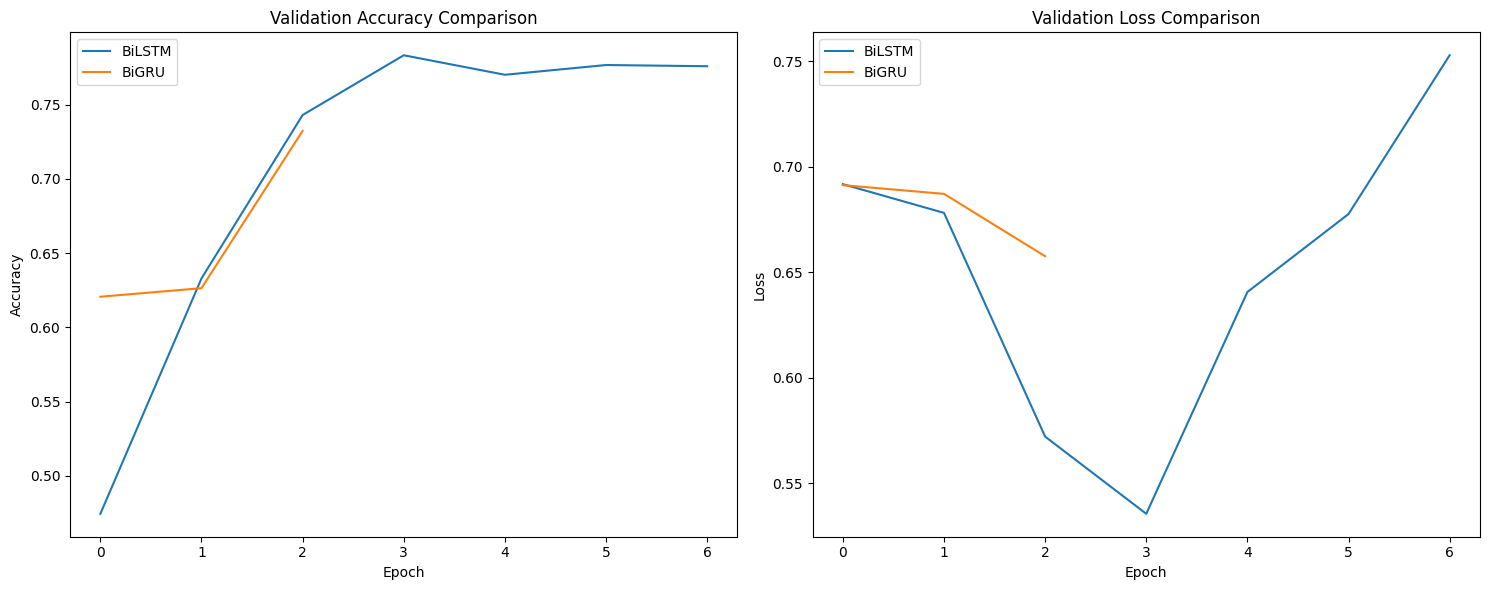

In [18]:
plt.figure(figsize=(15, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
for name, hist in history.items():
    plt.plot(hist.history['val_accuracy'], label=name)
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
for name, hist in history.items():
    plt.plot(hist.history['val_loss'], label=name)
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
print("\nModel Performance Evaluation:")
for name, model in models.items():
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


Model Performance Evaluation:
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step

BiLSTM Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       869
           1       0.78      0.74      0.76       654

    accuracy                           0.80      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

F1 Score: 0.7594
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step

BiGRU Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.66       869
           1       0.55      0.56      0.56       654

    accuracy                           0.62      1523
   macro avg       0.61      0.61      0.61      1523
weighted avg       0.62      0.62      0.62      1523

F1 Score: 0.5564


In [20]:
# Load and process test data
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])
test_padded = pad_sequences(test_sequences, maxlen=100, truncating='post')

In [21]:
# Ensemble Prediction
ensemble_preds = np.zeros((len(test_padded),))
for name, model in models.items():
    ensemble_preds += model.predict(test_padded).flatten()
ensemble_preds = (ensemble_preds / len(models) > 0.5).astype(int)


102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step


In [22]:
# Create Submission File 
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': ensemble_preds
})
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!
